# Optimization

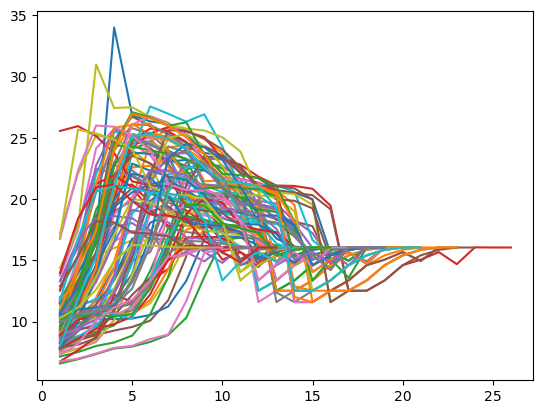

True
optimal design variable:
   capture_width       5.200 [m]
   pen_diameter       10.000 [m]
   pen_height          3.000 [m]
   spacing           123.089 [m]
   stock_density      15.000 [kg/m^3]
   pen_depth          16.861 [m]
   num_pens            6.000 [-]
----------------------------------------
optimal WEC rated power:
   P_rated          92.883 [kW]
----------------------------------------
optimal objective function terms:
   cost_per_yield     16.054 [$/kg]
   price          289379.193 [$]
   fish_yield      18024.888 [kg]
----------------------------------------
optimal price break down:
   wec price        98365.337 [$]
   pen price       141371.669 [$]
   fish feed price  36092.187 [$]
----------------------------------------
optimal constraints:
   P_gen_cons               -0.000 [kWh]
   fish_yield_cons       72513.005 [kg]
   env_Umin_cons             0.190 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons      

In [8]:
import modules
from modules import Aqua_Obj
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

max_iter = 10000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(title, aqua_obj):
    print_bold(title+" objective function terms:")
    print(' '*2, "cost_per_yield", "{:10.3f}".format(aqua_obj.cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(aqua_obj.price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(aqua_obj.fish_yield), '[kg]')
    print("-"*40)

def print_price_breakdown(title, aqua_obj):
    print_bold(title+" price break down:")
    print(' '*2, "wec price      ", "{:10.3f}".format(aqua_obj.wec.price), '[$]')
    print(' '*2, "pen price      ", "{:10.3f}".format(aqua_obj.pen.price), '[$]')
    print(' '*2, "fish feed price", "{:10.3f}".format(aqua_obj.fish_feed_price), '[$]')
    print("-"*40)
    
def print_P_rated(title, aqua_obj):
    print_bold(title+" WEC rated power:")
    print(' '*2, "P_rated     ", "{:10.3f}".format(aqua_obj.wec.P_rated), '[kW]')
    print("-"*40)

def print_carrying_capacity(title, aqua_obj):
    print_bold(title+" carrying capacity:")
    print(' '*2, "TPF_O2              ", "{:10.3f}".format(aqua_obj.pen.TPF_O2), '[kg fish/year]')
    print(' '*2, "Carrying Capacity   ", "{:10.3f}".format(aqua_obj.carrying_capacity), '[kg fish]')
    print("-"*40)
    
def print_ineq_cons(title,aqua_obj):
    print_bold(title+" constraints:")
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(aqua_obj.P_gen_cons), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(aqua_obj.fish_yield_cons), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(aqua_obj.env_Umin_cons), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(aqua_obj.env_Umax_cons), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(aqua_obj.env_tempmin_cons), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(aqua_obj.env_tempmax_cons), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(aqua_obj.env_salinitymin_cons), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(aqua_obj.env_salinitymax_cons), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(aqua_obj.env_O2_min_cons), '[mg/l]')
    print("-"*40)
            
def optimize_result(x_name, x_list, x_unit, res_opt, p):
    aqua_opt_obj = Aqua_Obj(res_opt.x, x_name, p) 
    
    col_width = len(max(x_list, key=len))
    print(res_opt.success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res_opt.x[i]), x_unit[i])
    
    print(' '*2, "num_pens      ", "{:10.3f}".format(aqua_opt_obj.pen.n), '[-]')
    print("-"*40)
    
    print_P_rated("optimal",aqua_opt_obj)
    print_objective("optimal",aqua_opt_obj)
    print_price_breakdown("optimal",aqua_opt_obj)
    print_ineq_cons("optimal",aqua_opt_obj)
    print_carrying_capacity("optimal",aqua_opt_obj)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','x_disc_pen','p_pen','x_env','p_wec','p_fish_salmon', 'x_es', 'p_es']

wec_types = ['point_absorber_RM3'] #,'attenuator','terminator','point_absorber_RM3']

# design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# parameters
param_name = ['x_type_wec','x_disc_pen']
param_val = {}


#optimization
best_idx = 0
res={}

fig, ax = plt.subplots(1,1)
opt_res_history = []
cons_history = []
iteration_history = []

for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    param_val['num_pens'] = 6
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    iteration = np.linspace(1,max_iter+1,max_iter+1)
    
    for n_test in range(100):
        x0 = []
        for i0 in range(len(x_bnds)):
            x0.append(np.random.uniform(low=x_bnds[i0][0], high=x_bnds[i0][1]))
    
        res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    

        if res[i].fun < res[best_idx].fun:
            best_idx = i
        
        ax.plot(iteration, op_obj.f)
        
        opt_res_history.append(op_obj.f)
        iteration_history.append(op_obj.count)
        cons_history.append(op_obj.ineq)

plt.show()

optimize_result(x_name, x_list, x_unit, res[best_idx], p)

# Plot fish growth and fish oxygen demand

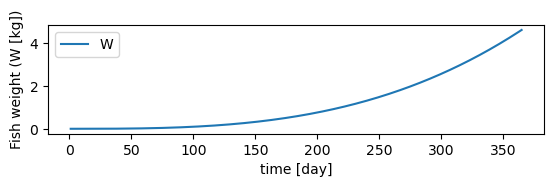

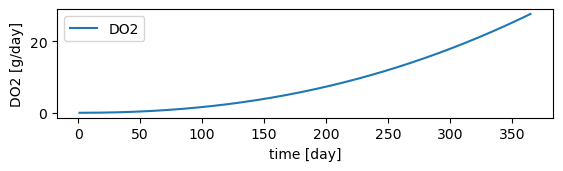

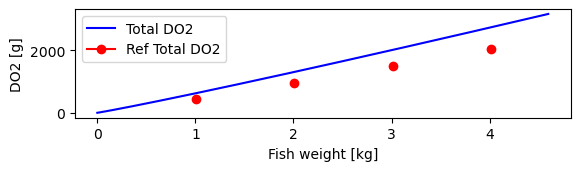

DO2 for 1kg fish 592.658417961274
DO2 for 2kg fish 1267.6196206239329
DO2 for 3kg fish 1968.158657940374
DO2 for 4kg fish 2690.091351663788
fish weight after 365 days 4597.867265255341


In [9]:
aqua_opt_obj = Aqua_Obj(res[best_idx].x, x_name, p) 
aqua_opt_obj.plot_variable()

# Plot objective function and constraints

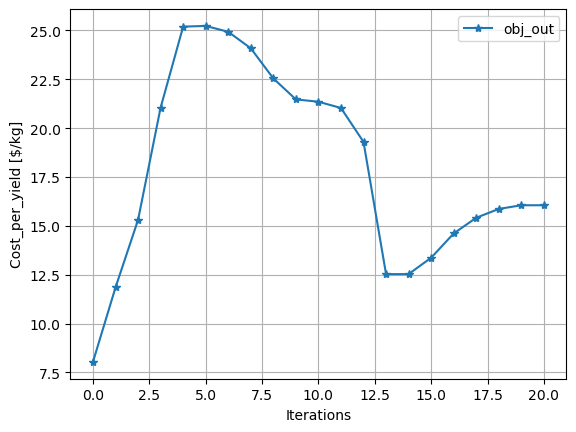

In [10]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

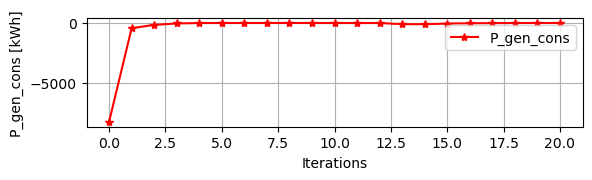

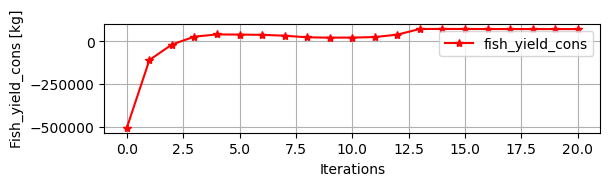

In [11]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
